# Extracting single beat; QRS peak at 2048

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew

In [2]:
df = pd.read_csv("../data/beats_summary_frame.csv")
df.head()

,subject,channel,n_peaks,inter_beat_sd,peaks,mode_n_peaks,mode_count,hr,avg_inter_beat_sd,retain_subject
0,0,0,9.0,9.096703,[ 211 670 1118 1560 2002 2443 2885 3314 3743],9.0,10,54.0,9.104809,True
1,0,1,9.0,9.137833,[ 212 671 1119 1561 2004 2444 2886 3316 3744],9.0,10,54.0,9.104809,True
2,0,2,3.0,656.500000,[1123 1565 3320],9.0,10,54.0,9.104809,True
3,0,3,9.0,9.124144,[ 211 670 1118 1560 2003 2444 2885 3315 3743],9.0,10,54.0,9.104809,True
4,0,4,9.0,9.096703,[ 210 669 1117 1559 2001 2443 2884 3313 3742],9.0,10,54.0,9.104809,True


In [3]:
df['retain_subject'].value_counts()

retain_subject
False    187668
True      52344
Name: count, dtype: int64

In [4]:
df0 = df[df['subject'] == 0].copy()

In [5]:
df0

,subject,channel,n_peaks,inter_beat_sd,peaks,mode_n_peaks,mode_count,hr,avg_inter_beat_sd,retain_subject
0,0,0,9.0,9.096703,[ 211 670 1118 1560 2002 2443 2885 3314 3743],9.0,10,54.0,9.104809,True
1,0,1,9.0,9.137833,[ 212 671 1119 1561 2004 2444 2886 3316 3744],9.0,10,54.0,9.104809,True
2,0,2,3.0,656.500000,[1123 1565 3320],9.0,10,54.0,9.104809,True
3,0,3,9.0,9.124144,[ 211 670 1118 1560 2003 2444 2885 3315 3743],9.0,10,54.0,9.104809,True
4,0,4,9.0,9.096703,[ 210 669 1117 1559 2001 2443 2884 3313 3742],9.0,10,54.0,9.104809,True
5,0,5,9.0,9.110434,[ 214 673 1121 1563 2005 2446 2888 3318 3746],9.0,10,54.0,9.104809,True
6,0,6,9.0,9.110434,[ 213 672 1120 1562 2004 2445 2887 3317 3745],9.0,10,54.0,9.104809,True
7,0,7,9.0,9.096703,[ 217 676 1124 1566 2008 2449 2891 3320 3749],9.0,10,54.0,9.104809,True
8,0,8,9.0,9.026870,[ 216 675 1124 1566 2008 2449 2890 3320 3749],9.0,10,54.0,9.104809,True
9,0,9,9.0,9.137833,[ 208 667 1115 1557 2000 2440 2882 3312 3740],9.0,10,54.0,9.104809,True


In [6]:
np.save("../data/one_beat_ids_part16.npy", df[df['retain_subject']]['subject'].unique())

In [7]:
mask_df = df.groupby(
    'subject'
)['retain_subject'].max().reset_index()

In [8]:
# Assign new IDs associated with the traces to the filtered dataframe
subject_id_mapping = {}
for ind, subject_id in  zip(
    mask_df[mask_df['retain_subject']]['subject'].reset_index(drop=True).index, 
    mask_df[mask_df['retain_subject']]['subject'].reset_index(drop=True).values):
    subject_id_mapping[subject_id] = ind
df.loc[:, 'new_subject_id'] = df['subject'].map(subject_id_mapping)
df.sample()

,subject,channel,n_peaks,inter_beat_sd,peaks,mode_n_peaks,mode_count,hr,avg_inter_beat_sd,retain_subject,new_subject_id
204776,17064,8,15.0,164.116077,[ 358 422 788 850 1283 1642 1704 2072 2133 ...,9.0,6,54.0,4.198764,False,NaN


In [9]:
filename = "../data/exams_part16.hdf5"
with h5py.File(filename, "r") as f:
    print("Keys in the HDF5 file:", list(f.keys()))
    data_array = f['tracings'][()]
    exam_ids = f['exam_id'][()]


Keys in the HDF5 file: ['exam_id', 'tracings']


In [10]:
exam_ids = exam_ids[mask_df['retain_subject']]
len(exam_ids)

4362

In [11]:
data_array = data_array[mask_df['retain_subject'], :, :]
data_array.shape

(4362, 4096, 12)

In [12]:
one_beat_array = np.empty(data_array.shape)
one_beat_array.shape

(4362, 4096, 12)

[212, 671, 1119, 1561, 2004, 2444, 2886, 3316, 3744]


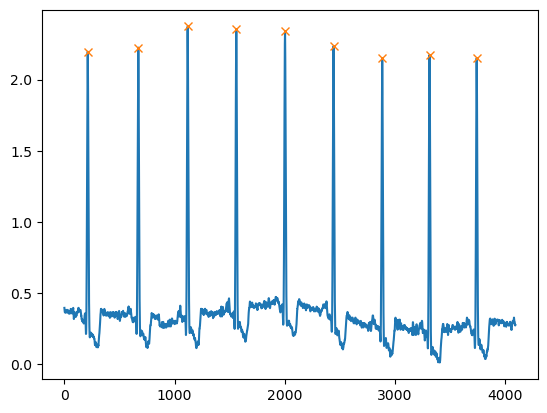

In [13]:
# Play around with different subjects and channels to see what peaks are detected.
subject = 0  
channel = 1
series = data_array[subject, :, channel]
if skew(series) < 0:
    series = -series
    print("found skew")
# peaks, _ = find_peaks(series, prominence=(peak_prominence_for_detection, None))
peaks = df[
    (df['subject'] == subject) &
    (df['channel'] == channel)
]['peaks'].values[0]

if isinstance(peaks, str):
    peaks = [int(item) for item in peaks.replace('[', '').replace(']', '').split()]
print(peaks)
# plt.plot(data_array[subject, :, channel])
plt.plot(data_array[subject, :, 1])

plt.plot(peaks, data_array[subject, :, channel][peaks], "x")
plt.show()

In [14]:
i = 0
trace = data_array[i, :, :]

In [15]:
peaks

[212, 671, 1119, 1561, 2004, 2444, 2886, 3316, 3744]

In [ ]:
# Select subject and channel to pick peaks
PEAK_AT = 2048

# this is the index for the data_array, traces
for data_array_index in range(len(data_array)):
    
    # associated dataframe index:
    subject = int(df[df['new_subject_id'] == data_array_index]['subject'].values[0])
    
    # The first channel that has the mode number of peaks
    channel = int(df[
        (df['subject'] == subject) &
        (df['n_peaks'] == df['mode_n_peaks'])
    ]['channel'].head(1).values[0])
    
    peaks = df[
        (df['subject'] == subject) &
        (df['channel'] == channel)
    ]['peaks'].values[0]
    if isinstance(peaks, str):
        peaks = [int(item) for item in peaks.replace('[', '').replace(']', '').split()]
    
    # find average length of the heartbeat
    i = 0
    beat_length = []
    while i < len(peaks) - 1:
        beat_length.append(peaks[1 + i] - peaks[i])
        i += 1
    avg_beat_len = np.ceil(np.array(beat_length).mean())
    
    # just over a 1/3 of the beat to before QRS complex
    back = int(np.ceil(avg_beat_len * 0.35))
    # just over 2/3 of the beat to after  QRS complex
    forward = int(np.ceil(avg_beat_len * 0.70))
    
    start = PEAK_AT - back
    
    # average the heartbearts in one beat per channel
    # avg_beat = np.empty((int(back + forward), 12))
    trace = data_array[data_array_index, :, :]
    for chan in range(12):
        beats = []
        for peak in peaks:
            if peak - back >= 0 and peak + forward <= 4096:
                one_beat = trace[int(peak - back):int(peak + forward), chan]
            if one_beat.shape == back + forward:
                beats.append(one_beat)
        if data_array_index == 1:
            plt.plot(np.array(beats).mean(axis=0), label=chan)

        avg_one_chan = np.array(beats).mean(axis=0)
        one_beat_array[data_array_index, start: start+back + forward, chan] = avg_one_chan
    if data_array_index == 1:
        plt.legend()    

# create an array with n subject, 4096 X 12 dim per subject

/tmp/ipykernel_3885/1101525976.py:51: RuntimeWarning: Mean of empty slice.
  avg_one_chan = np.array(beats).mean(axis=0)
/tmp/ipykernel_3885/1101525976.py:49: RuntimeWarning: Mean of empty slice.
  plt.plot(np.array(beats).mean(axis=0), label=chan)


In [48]:
peaks

[471]

In [31]:
one_beat_array[data_array_index, start: start+back+forward, chan].shape

(465,)

In [30]:
start, start+back+forward

(1893, 2358)